# Sanity Checks for Saliency Maps Simple CNN MNIST Example

true: 3, pred: 3


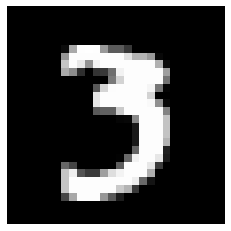

true: 6, pred: 6


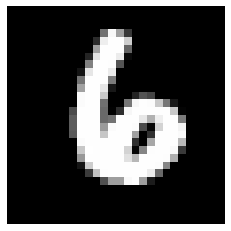

true: 5, pred: 5


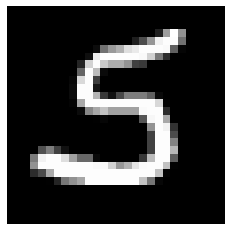

true: 1, pred: 1


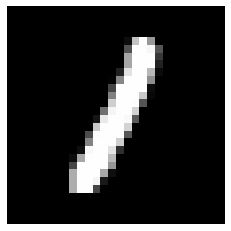

true: 6, pred: 6


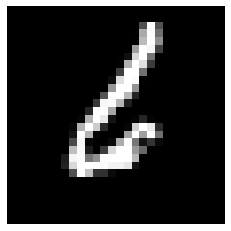

In [21]:
from torchvision import datasets, transforms
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util
from captum.attr import IntegratedGradients, Saliency, InputXGradient, GuidedBackprop, DeepLift

# load pretrained model
model = torch.load('models/cnn_mnist.pt', map_location=torch.device('cpu'))
model.eval()

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

# load dataset
dataset = datasets.MNIST('data', train=False, transform=transform, download=True)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 5, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

# print few examples
for image, label in test_loader:
    pred = model(image).argmax(axis=1)
    npimg = np.squeeze(np.squeeze(image.numpy()))
    plt.imshow(npimg, cmap='gray')
    print(f'true: {label[0]}, pred: {pred[0]}')
    plt.axis('off')
    plt.show()

In [22]:
# model architecture
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
)

In [23]:
# define module paths for cascading randomization
module_paths = [['linear2'], ['linear1'], ['conv2'], ['conv1']]

## Cascading Randomization: Specific Saliency Map

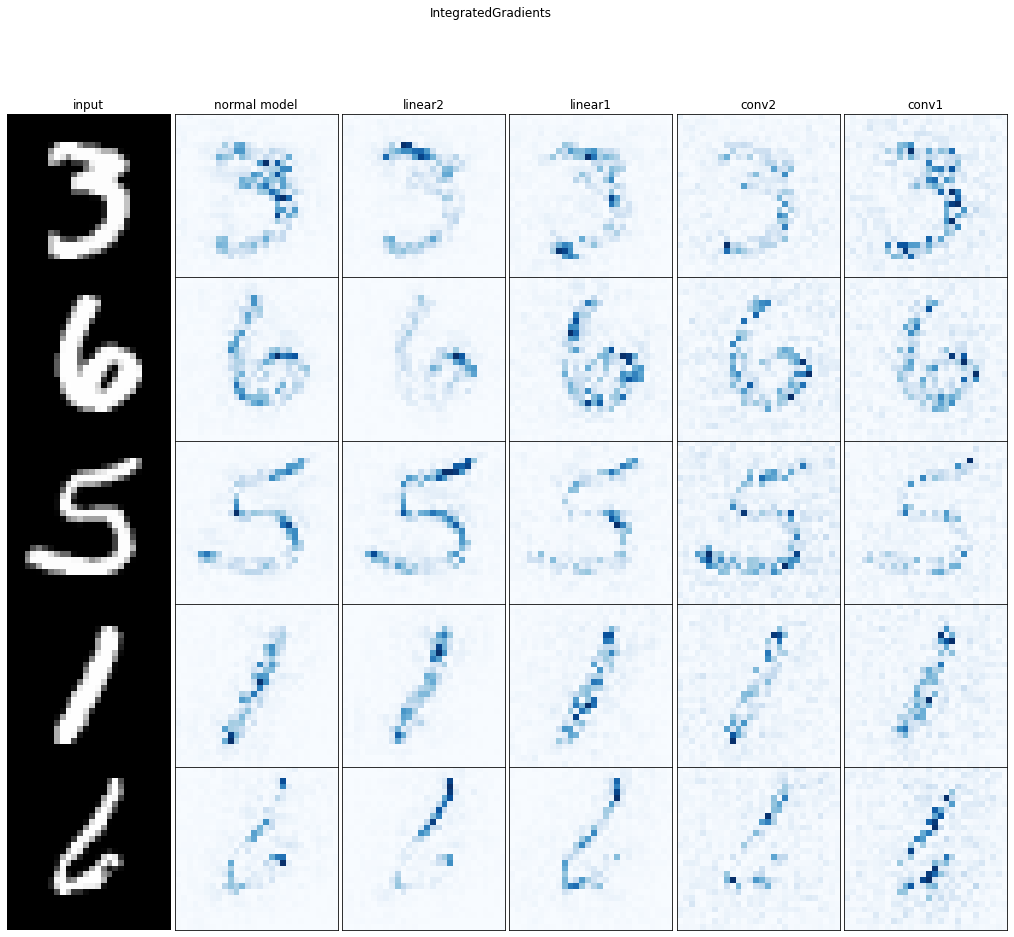

In [24]:
# visualize integrated gradients
fig, _ = util.visualize_cascading_randomization(model, module_paths, test_loader, IntegratedGradients)
fig.show()

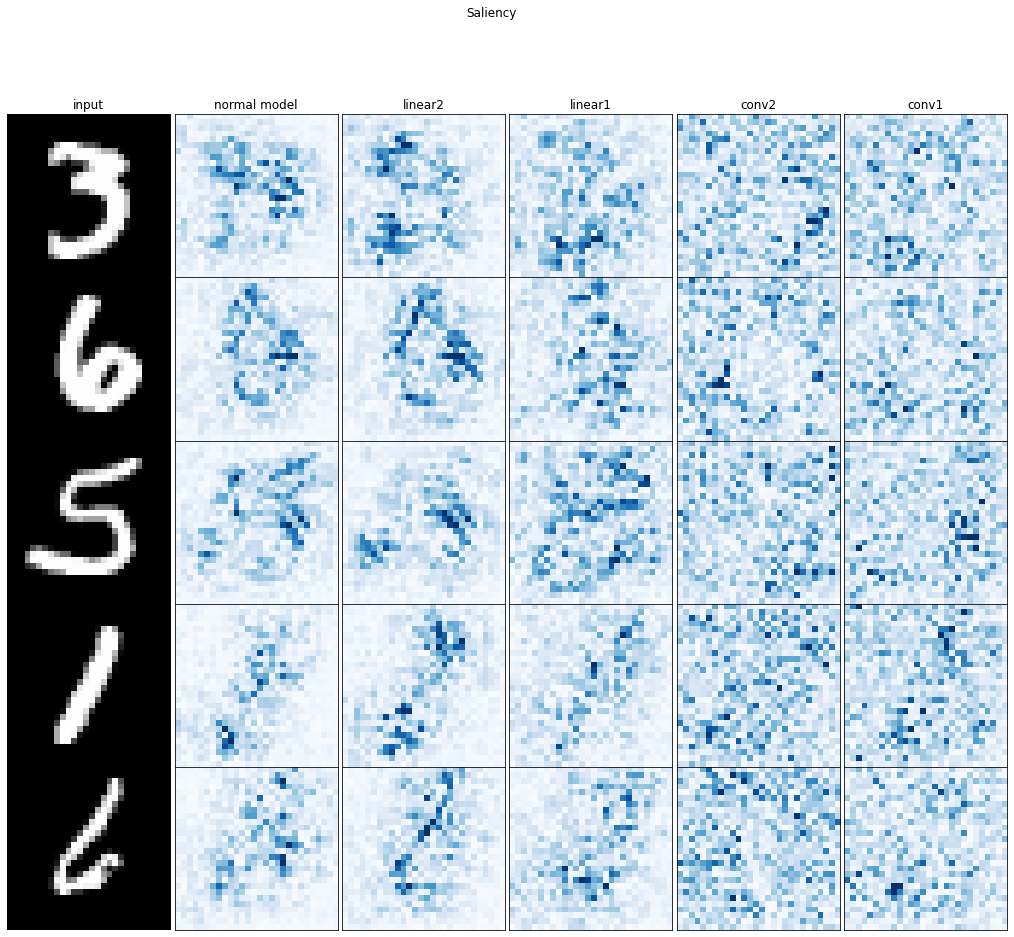

In [25]:
# visualize saliency (gradients)
fig, _ = util.visualize_cascading_randomization(model, module_paths, test_loader, Saliency)
fig.show()

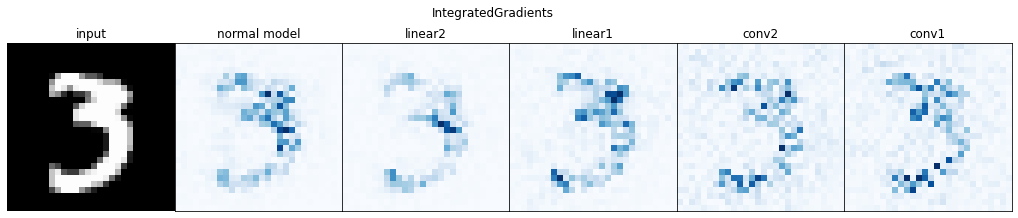

In [26]:
# single example case

for image, label in test_loader:
    fig, _ = util.visualize_cascading_randomization_single_example(model, module_paths, (image, label), IntegratedGradients)
    fig.show()
    break

### Cascading Randomization: Multiple Saliency Maps

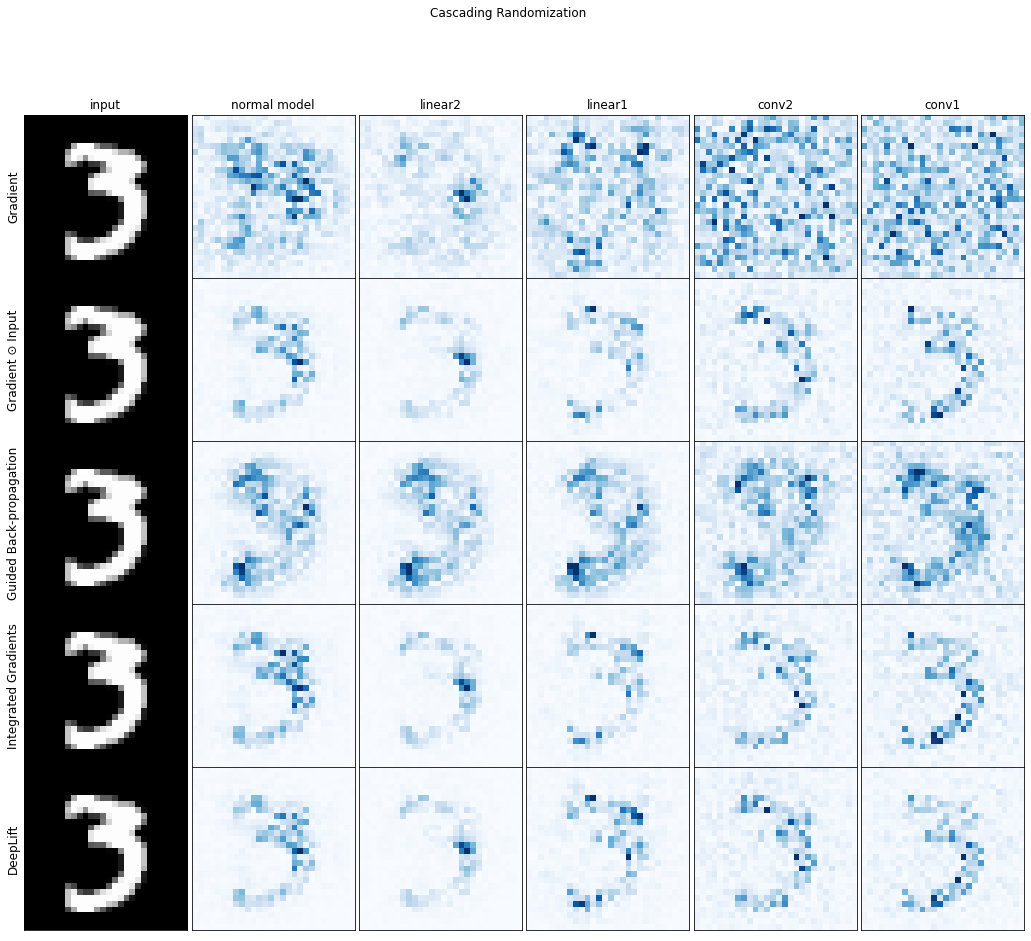

In [27]:
# multiple saliency maps for each example
for image, label in test_loader:
    fig, _ = util.visualize_cascading_randomization2(
        model,
        module_paths,
        (image, label),
        [Saliency, InputXGradient, GuidedBackprop, IntegratedGradients, DeepLift],
        ['Gradient', 'Gradient ⊙ Input', 'Guided Back-propagation', 'Integrated Gradients', 'DeepLift']
    )
    fig.show()
    break